In [16]:
import pandas as pd
import numpy as np
import ast
from typing import Final
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MultiLabelBinarizer,OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
#from sklearn.model_selection import Colu

def encode_genres(df: pd.DataFrame) -> pd.DataFrame:
  #đưa genres thành các id thôi
    """
    Parse cột 'genres' từ chuỗi JSON -> list id, rồi one-hot encode bằng MultiLabelBinarizer.
    """
    # Bước 1: Parse chuỗi JSON thành list id
    df["genre_ids"] = df["genres"].apply(
        lambda s: [d["id"] for d in ast.literal_eval(s)] if isinstance(s, str) and s.strip() else []
    )
    df.drop("genres",inplace=True,axis=1)
    # Bước 3: Ghép trở lại DataFrame
    return df
def load_tmdb_movies_df(input_csv_path: str) -> pd.DataFrame:
    """
    Đọc file TMDB, chuẩn hóa các cột số, giữ nguyên cột 'genres' và 'original_language'
    để xử lý sau bằng MultiLabelBinarizer và OneHotEncoder.
    """
    df = pd.read_csv(input_csv_path, encoding="utf-8")
    df=encode_genres(df)
    df["original_language"]=df["original_language"].apply(
        lambda x:x if x == "en" else "other"
    )
    #print(df["original_language"].value_counts())

    # Chuẩn hóa kiểu dữ liệu số
    numeric_cols = ['popularity', 'vote_average', 'vote_count', 'budget', 'revenue']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Loại bỏ revenue bị 0 hoặc NaN
    if 'revenue' in df.columns:
        df['revenue'] = df['revenue'].replace(0, np.nan)
        df = df.dropna(subset=['revenue'])

    # Giữ lại các cột cần thiết (không đụng tới genres và original_language)
    cols = ['id', 'genre_ids', 'popularity', 'vote_average', 'vote_count',
            'budget', 'original_language', 'revenue']
    df = df[[c for c in cols if c in df.columns]].copy()

    return df

def impute_zero_nan_with_mean(df: pd.DataFrame, cols):
    """Thay 0 và NaN bằng mean theo cột."""
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors='coerce').replace(0, np.nan)
        df[c] = s.fillna(s.mean(skipna=True))
    return df

def prepare_dataset_for_sklearn(df: pd.DataFrame, target: str = "revenue"):
    data = df.copy()
    #data=data.explode("genre_ids")
    # Chỉ impute 4 cột này (0/NaN -> mean)
    cols_impute = ["popularity", "vote_average", "vote_count", "budget"]
    impute_zero_nan_with_mean(data, cols_impute)

    numeric_features = ["popularity", "vote_average", "vote_count", "budget"]
    lang_feature = ["original_language"]
    gen_feature=["genre_ids"]
    mlb=MultiLabelBinarizer()
    genre_ohe=mlb.fit_transform(data["genre_ids"])
    genre_cols = [f"genre_{g}" for g in mlb.classes_]
    preprocessor=ColumnTransformer(
        [
            ("num","passthrough",numeric_features),
            ("lang",OneHotEncoder(sparse_output=False),lang_feature),
        ],
        remainder="drop"
    )


    X_transform = preprocessor.fit_transform(data)
    X=np.hstack([X_transform,genre_ohe])
    num_cols = numeric_features
    lang_cols = preprocessor.named_transformers_["lang"].get_feature_names_out(lang_feature)
    feature_cols = list(num_cols) + list(lang_cols) + genre_cols
    y = data[target].astype(float).values
    X=pd.DataFrame(X,columns=feature_cols)
    y=pd.DataFrame(y,columns=[target])
    return X, y, feature_cols

In [17]:
#print("start")
csv_path = "/content/tmdb_5000_movies.csv"
df = load_tmdb_movies_df(csv_path)
#df["original_language"].value_counts()
print(df.head(6))

       id          genre_ids  popularity  vote_average  vote_count     budget  \
0   19995  [28, 12, 14, 878]  150.437577           7.2       11800  237000000   
1     285       [12, 14, 28]  139.082615           6.9        4500  300000000   
2  206647       [28, 12, 80]  107.376788           6.3        4466  245000000   
3   49026   [28, 80, 18, 53]  112.312950           7.6        9106  250000000   
4   49529      [28, 12, 878]   43.926995           6.1        2124  260000000   
5     559       [14, 28, 12]  115.699814           5.9        3576  258000000   

  original_language       revenue  
0                en  2.787965e+09  
1                en  9.610000e+08  
2                en  8.806746e+08  
3                en  1.084939e+09  
4                en  2.841391e+08  
5                en  8.908716e+08  


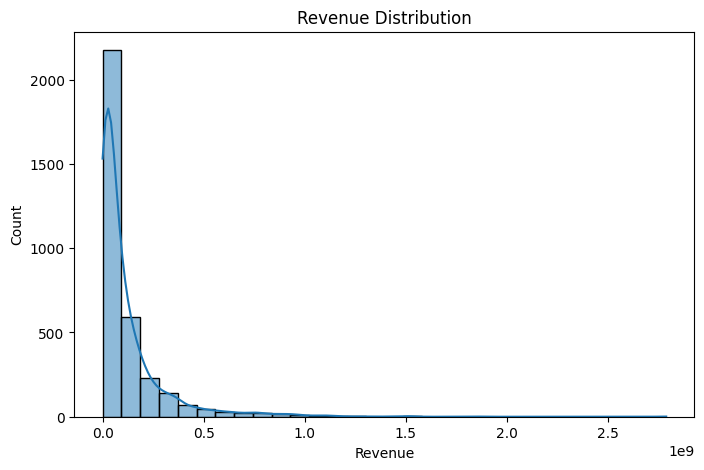

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["revenue"], bins=30, kde=True)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.show()

In [19]:
unique_genres = set([gid for lst in df["genre_ids"] for gid in lst])
print(unique_genres)

{10752, 12, 14, 16, 10769, 18, 27, 28, 10402, 35, 36, 37, 9648, 53, 80, 99, 878, 10749, 10751}


In [20]:
X, y, feature_cols = prepare_dataset_for_sklearn(df, target="revenue")


In [21]:
# ===========================================
#  🔹 BƯỚC 4: XÂY DỰNG MÔ HÌNH RANDOM FOREST
# ===========================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

import matplotlib.pyplot as plt
import numpy as np

# --- Chia dữ liệu train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

model=TransformedTargetRegressor(
    regressor=RandomForestRegressor(random_state=42),
    #random_state= seed ngẫu nhiên,seed=42=> khi mà ông gọi random=>7,10,30,1,4
    transformer=log_transformer
    )
from sklearn.model_selection import RandomizedSearchCV
#gridsearch
param_distrib={
    "regressor__n_estimators":[100,300,500,800],
    "regressor__max_depth":[None,10,20,30,40,50],
    "regressor__min_samples_split":[2,5,10,20],
    "regressor__min_samples_leaf":[1,2,5,10],
    "regressor__max_features":["sqrt","log2",0.3,0.5,None],
    "regressor__bootstrap":[True,False]
}
# 1 mô hình machine learning, sẽ ko biết chọn các tham số trên như nào cho hợp lý
#dòng randomied_search
rnd=RandomizedSearchCV(
    model,# cái mô hình
    param_distributions=param_distrib,#
    n_iter=30,# chạy 30 lần, chọn mô hình tốt nhất trong 30 lần
    cv=5,
    scoring="neg_root_mean_squared_error",
    #sqrt((y_train_du_doan-y_train_that)^2)/ (samples)
    n_jobs=-1,#tận dụng gpu chạy song song
    random_state=42

)

In [22]:
len(X_train)

2700

In [23]:
corrs = df[["popularity", "vote_average", "vote_count", "budget", "revenue"]].corr()
print(corrs["revenue"].sort_values(ascending=False))

revenue         1.000000
vote_count      0.758337
budget          0.708214
popularity      0.605994
vote_average    0.180503
Name: revenue, dtype: float64


In [24]:
y_train.values

array([[2.03742010e+07],
       [2.14015089e+08],
       [3.20000000e+06],
       ...,
       [7.74770080e+07],
       [2.73552592e+08],
       [1.50277000e+05]])

In [25]:
rnd.fit(X_train, y_train)# chạy 15p
print(rnd.best_params_)


{'regressor__n_estimators': 800, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 0.5, 'regressor__max_depth': None, 'regressor__bootstrap': False}


In [26]:
best_model=rnd.best_estimator_


y_pred=best_model.predict(X_test)
#dự đoán doanh thu trên X_test

In [27]:
#X_test,y_test
#X_train,y_train

In [28]:
print(y_pred[:10])
print(y_test[:10])

[[7.38499628e+05]
 [5.21735326e+08]
 [9.48643771e+07]
 [1.09513514e+07]
 [1.08585325e+08]
 [6.44235018e+06]
 [2.46758600e+08]
 [6.74080796e+06]
 [7.74350957e+07]
 [1.50432544e+08]]
          revenue
3133    7800000.0
144   746921274.0
1231   79700000.0
3000   33965843.0
1052   48190704.0
2862   40100000.0
410   237681299.0
2574   21786738.0
315   102000000.0
2080  121463226.0


In [29]:
y_test

,revenue
3133,7800000.0
144,746921274.0
1231,79700000.0
3000,33965843.0
1052,48190704.0
...,...
1565,54926886.0
2755,54215416.0
3049,11176469.0
2436,15250000.0


In [30]:
-rnd.best_score_
#random_search, chọn ra mô hình tốt nhất dựa trên neg_root_mean_squared
#rnd.best_score_ là neg_root_mean_squared lớn nhất

np.float64(88851101.84717025)

In [31]:
#dự đoán revenue
#y_predict là cái mảng giá trị dự đoán
#y_test là mảng giá trị thực
#đồ thị so sánh giữa y_predict và y_test
#matplotlib hay sns
#importances = best_model.regressor_.feature_importances_
#vẽ đồ thị biểu thị sự tuyến tính giữa các features và feature cần dự đoán
#metrics , root mean squared error,
#from sklearn.metrics import MSE
#vẽ ????
#vẽ ra các hyperapameter của từng decision tree trong random_forest, ví dụ max_depth
# kết luận
#tập train là 80%, test là 20%
# dùng mô hình predict trên y_train=> y_train_predict => so sánh với y_train => tính MSE_train
## dùng mô hình predict trên y_test=> test_predict => so sánh với test => tính MSE_test
# nếu MSE_train lớn hơn MSE_test quá nhiều=> mô hình perform tệ trên tập test=> overfitting
# nếu mse_train và mse_test đều lỏ => underfit
#so sánh mse với y.mean()

In [32]:
y_train

,revenue
2624,20374201.0
790,214015089.0
3068,3200000.0
1220,10300000.0
2415,13960203.0
...,...
1095,161834276.0
1130,120175290.0
1294,77477008.0
860,273552592.0


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- Dự đoán trên train và test ---
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# --- Metrics ---
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"MSE train: {mse_train:.2f}, RMSE train: {rmse_train:,.2f}, R2 train: {r2_train:.3f}")
print(f"MSE test : {mse_test:.2f}, RMSE test : {rmse_test:,.2f}, R2 test : {r2_test:.3f}")
























MSE train: 1103265448334052.50, RMSE train: 33,215,439.91, R2 train: 0.962
MSE test : 15100617485585192.00, RMSE test : 122,884,569.76, R2 test : 0.707


In [34]:
# --- So sánh MSE với trung bình của y ---
y_mean_train = y_train.mean().values[0]
print(f"Mean revenue in dataset: {y_mean_train:.2f}")
#33,666 nghìn tỷ đồng
print(f"root mean square error: {rmse_train}")
'''
Doanh thu trung bình của phim: ~111 triệu USD
Sai số trung bình (RMSE): ~33 triệu USD
#root mean square error: sai số trung bình
'''

Mean revenue in dataset: 111554453.78
root mean square error: 33215439.908784173


'\nDoanh thu trung bình của phim: ~111 triệu USD\nSai số trung bình (RMSE): ~33 triệu USD\n#root mean square error: sai số trung bình\n'

In [35]:
# --- So sánh MSE với trung bình của y ---
y_mean_test = y_test.mean().values[0]
print(f"Mean revenue in dataset: {y_mean_test:.2f}")
#33,666 nghìn tỷ đồng
print(f"root mean square error: {rmse_test}")
'''
Doanh thu trung bình của phim: ~138 triệu USD
Sai số trung bình (RMSE): ~122 triệu USD
'''

Mean revenue in dataset: 138906541.77
root mean square error: 122884569.76197293


'\nDoanh thu trung bình của phim: ~138 triệu USD\nSai số trung bình (RMSE): ~122 triệu USD\n'

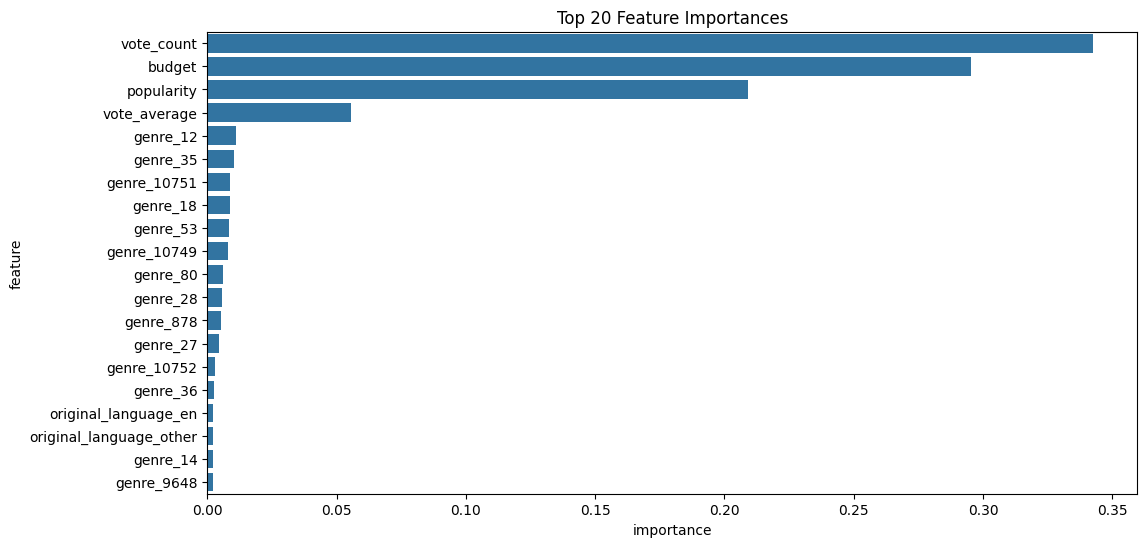

In [36]:
# --- Feature Importance ---
importances = best_model.regressor_.feature_importances_
feature_names = X_train.columns
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(20))  # Top 20 features
plt.title("Top 20 Feature Importances")
plt.show()

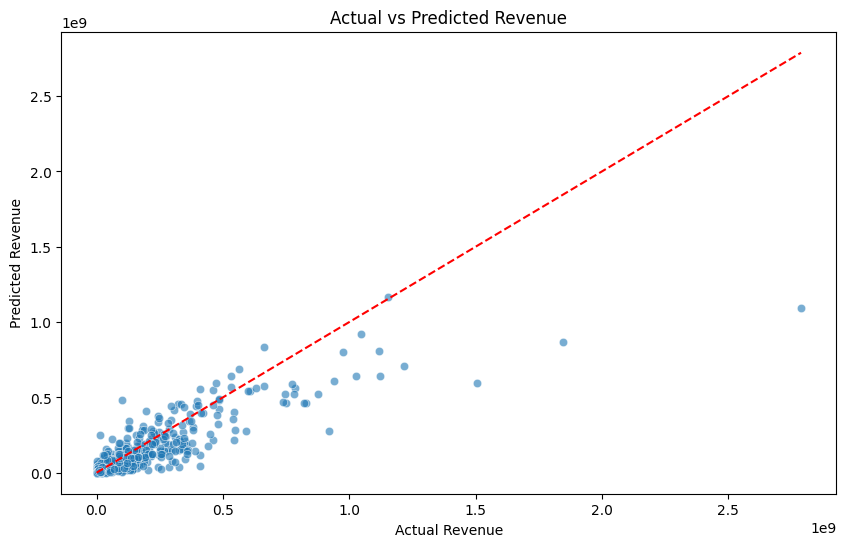

In [37]:
# --- Vẽ biểu đồ so sánh y_pred và y_true ---
plt.figure(figsize=(10,6))
#độ lớn của cái hình vẽ

sns.scatterplot(x=y_test.values.flatten(), y=y_test_pred.flatten(), alpha=0.6)
#biểu đồ phân tán
#x=[0,4,7]
#y=[1,6,9]
#vẽ hệ tọa độ Oxy, A(0,1),B(4,6),C(7,9)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # đường y=x
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.show()
#mô hình chưa dự đoán tốt  được cái phim có revenue cao, các phim ăn khách
#dự đoán khá tốt trên các phim có doanh thu thấp

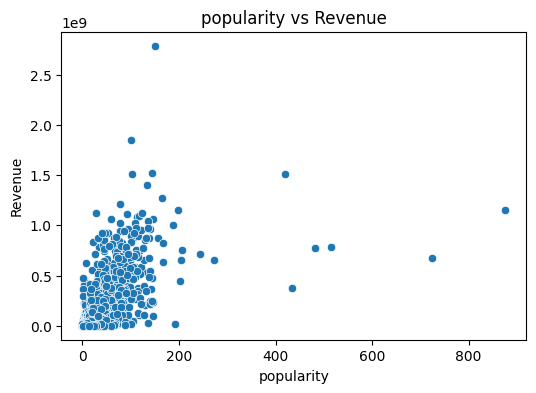

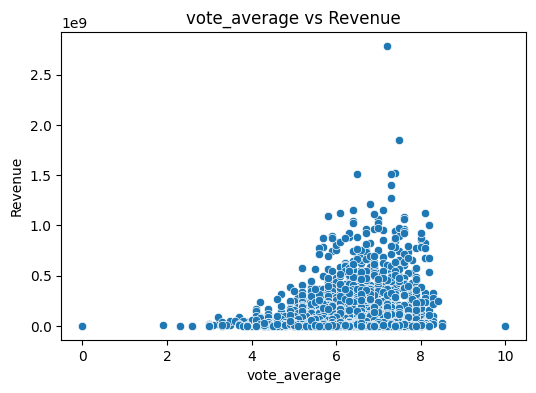

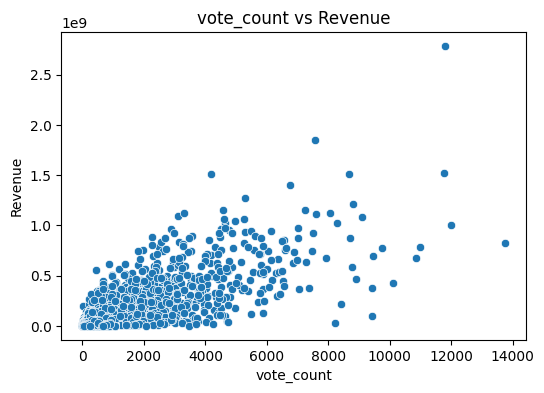

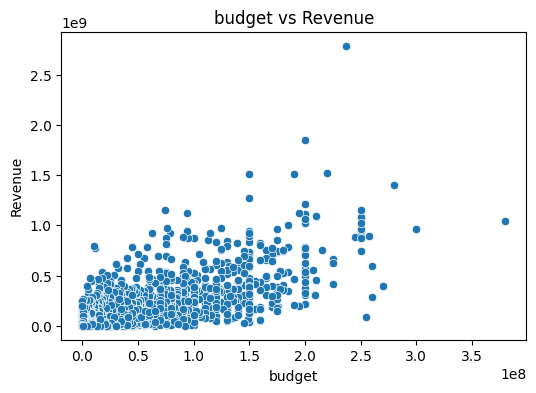

In [38]:
# --- Scatter plots giữa các numeric feature và revenue ---
numeric_features = ["popularity", "vote_average", "vote_count", "budget"]
for f in numeric_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[f], y=df["revenue"])
    plt.title(f"{f} vs Revenue")
    plt.xlabel(f)
    plt.ylabel("Revenue")
    plt.show()


Number of trees in the forest: 800


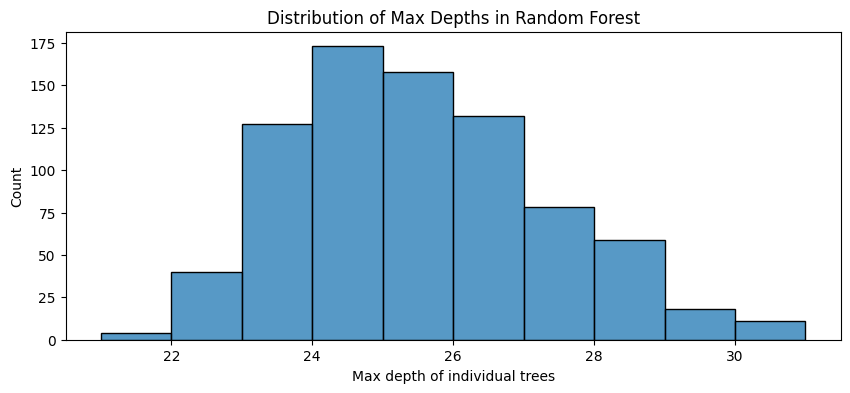

In [39]:
# --- Hyperparameters của từng cây trong Random Forest ---
n_trees = len(best_model.regressor_.estimators_)
print(f"Number of trees in the forest: {n_trees}")

max_depths = [tree.get_depth() for tree in best_model.regressor_.estimators_]
plt.figure(figsize=(10,4))
sns.histplot(max_depths, bins=10, kde=False)
plt.xlabel("Max depth of individual trees")
plt.title("Distribution of Max Depths in Random Forest")
plt.show()

In [40]:

# --- Kết luận về overfitting / underfitting ---
print("Kết luận:")
print(rmse_train)
print(rmse_test)
#rmse_test lớn hơn rmse_train quá nhiều =>overfitting

Kết luận:
33215439.908784173
122884569.76197293


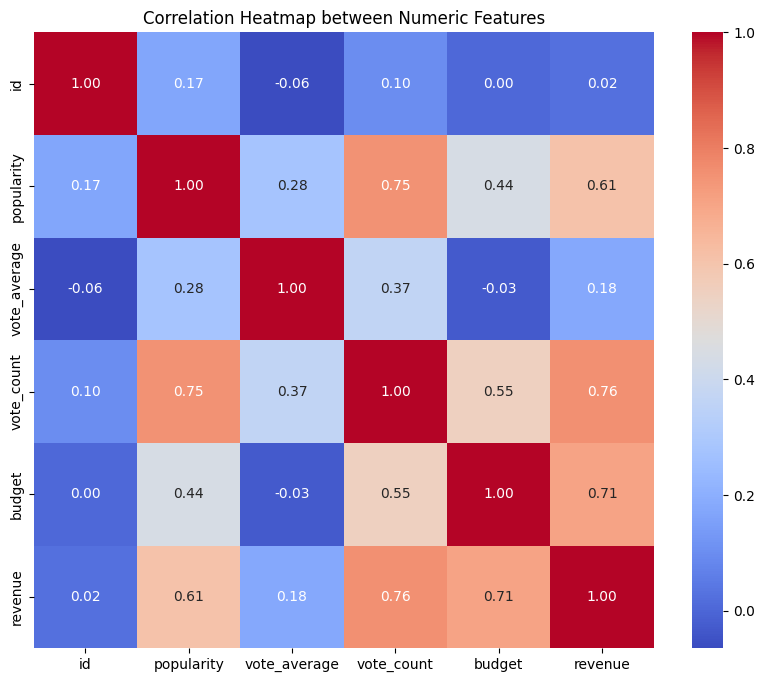

In [41]:
# --- 1. Phân tích tương quan ---
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap between Numeric Features")
plt.show()

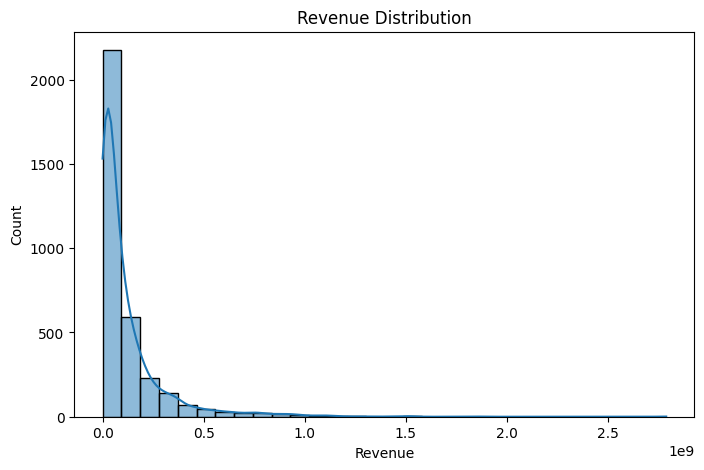

In [42]:
# --- 2. Phân tích phân phối doanh thu ---
plt.figure(figsize=(8,5))
sns.histplot(df["revenue"], bins=30, kde=True)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.show()

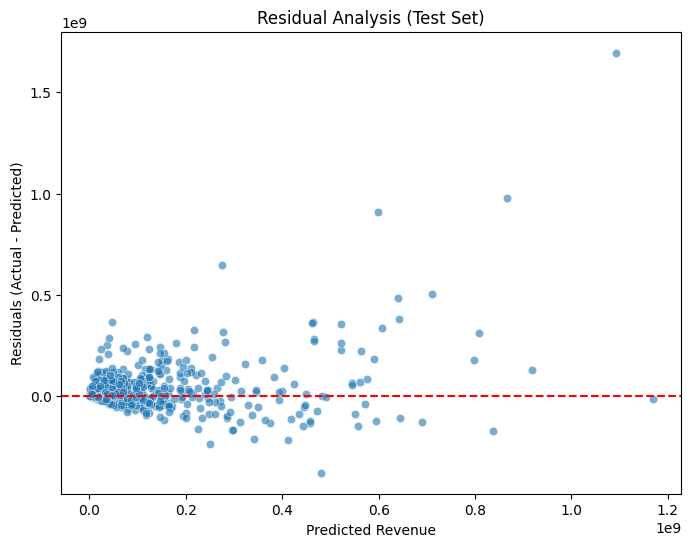

In [43]:
# --- 3. Residual Analysis ---
y_test_flat = np.ravel(y_test)
y_test_pred_flat = np.ravel(y_test_pred)
residuals = y_test_flat - y_test_pred_flat

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_pred_flat, y=residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Analysis (Test Set)")
plt.show()
#kết luân những phim có doanh thu cao bị dự đoán lệch

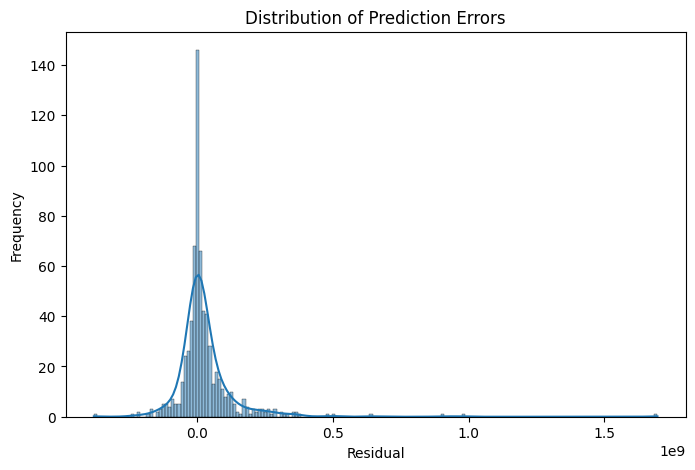

In [44]:
# --- 4. Phân phối sai số ---
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

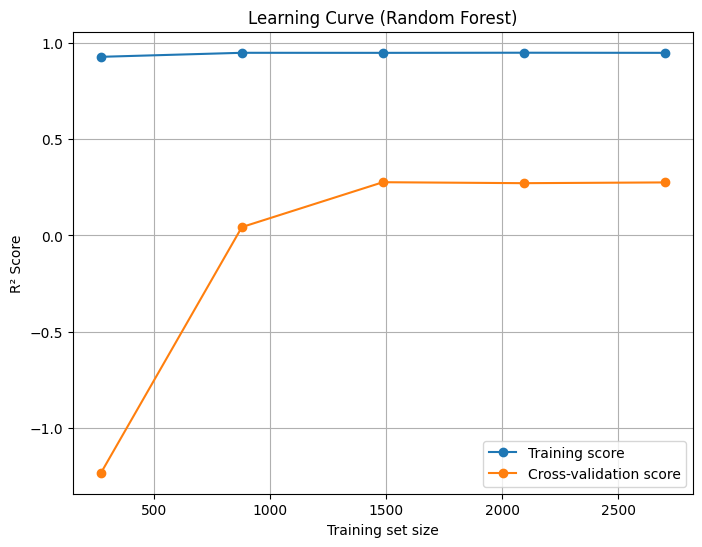

In [45]:
# --- 5. Learning Curve ---
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X, y.values.ravel(),
    cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training set size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()
